In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm

import re
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

2024-05-27 02:15:02.936973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 02:15:04.075415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [3]:
file_path = '/home/ciprian/Pythonvscode/Pythonprograms/samsum-test.csv'
df = pd.read_csv(file_path)

# Ensure the CSV contains the expected columns
assert 'dialogue' in df.columns and 'summary' in df.columns, "The CSV file must contain 'dialogue' and 'summary' columns"
df = df.drop(columns=['id'])

In [4]:
# Rename columns to match the expected format in the rest of the script
df = df.rename(columns={'dialogue': 'src', 'summary': 'trg'})

In [5]:
df['src_len'] = [len(text.split()) for text in df.src]
df['trg_len'] = [len(text.split()) for text in df.trg]

In [6]:
df.head()

,src,trg,src_len,trg_len
0,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...,71,14
1,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...,82,11
2,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...,106,27
3,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...,85,11
4,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....,207,42


In [7]:
def src_preprocessing(data, col):
    data[col] = data[col].astype(str)
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub("[^A-Za-z\s]", "", x))
    data[col] = data[col].apply(lambda x: re.sub("\s+", " ", x))
    data[col] = data[col].apply(lambda x: " ".join([word for word in x.split()]))
    return data

In [8]:
def trg_preprocessing(data, col):
    data[col] = data[col].astype(str)
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub(r'\d', '', x))
    data[col] = data[col].apply(lambda x: re.sub(r'\s+', ' ', x))
    data[col] = data[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    data[col] = data[col].apply(lambda x: x.strip())
    data[col] = "<sos> " + data[col] + " <eos>"
    return data

In [9]:
df = src_preprocessing(df, 'src')
df = trg_preprocessing(df, 'trg')

In [10]:
# Filtering based on summarization length criteria
df = df[~(df['src_len'] < 50) & ~(df['src_len'] > 300)]
df = df[~(df['trg_len'] < 10) & ~(df['trg_len'] > 50)]

In [11]:
SRC_MAXLEN = np.max(df['src_len'])
TRG_MAXLEN = np.max(df['trg_len'])

In [12]:
def Vectorization(col, MAXLEN):
    sents = df[col].tolist()
    corpus = [word for text in df[col] for word in text.split()]
    vocab_size = len(Counter(corpus))

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>",
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')

    tokenizer.fit_on_texts(sents)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Ensure special tokens are in the tokenizer
    if '<sos>' not in tokenizer.word_index:
        tokenizer.word_index['<sos>'] = len(tokenizer.word_index) + 1
        tokenizer.index_word[tokenizer.word_index['<sos>']] = '<sos>'
    if '<eos>' not in tokenizer.word_index:
        tokenizer.word_index['<eos>'] = len(tokenizer.word_index) + 1
        tokenizer.index_word[tokenizer.word_index['<eos>']] = '<eos>'

    seqs = tokenizer.texts_to_sequences(sents)
    pad_seqs = pad_sequences(seqs, maxlen=MAXLEN, padding='post')

    return pad_seqs, tokenizer

In [13]:
src_seqs, src_tokenizer = Vectorization('src', SRC_MAXLEN)
trg_seqs, trg_tokenizer = Vectorization('trg', TRG_MAXLEN)

In [14]:
print(f"The size of the source vocab size: {len(src_tokenizer.word_index)}\n")
print(f"The size of the target vocab size: {len(trg_tokenizer.word_index)}\n")

The size of the source vocab size: 5664

The size of the target vocab size: 2870



In [15]:
trg_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in trg_seqs[15] if idx != 0])
print(f"{trg_seqs[15]} \n\n {trg_sent}")

[   2  724   16   42  510  156   20 1223  183  136   99   10    7  383
    4    7  725   17   39  726   38 1224  306   61   29   14  124  212
   12    6  510  107    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 

 sos gloria has an exam soon it lasts hours emma sent her a link to a website with some texts from previous years so that she can prepare for the exam better eos


In [16]:
BATCH_SIZE = 128

In [17]:
ds = TensorDataset(torch.LongTensor(src_seqs), torch.LongTensor(trg_seqs))

In [18]:
torch.manual_seed(42)
ds_dataloader = DataLoader(
    dataset=ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [19]:
print(f"The size of the dataloader {len(ds_dataloader)} batches of {BATCH_SIZE}")

The size of the dataloader 8 batches of 64


# <b>6 <span style='color:#9146ff'>|</span> Build our model</b>

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>1-</b> Self Attention</span>

In [20]:
def SelfAttention(q, k, v, mask):
    attention_logits = torch.matmul(q, k.transpose(-2, -1)).to(DEVICE)
    scaling = torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)).to(DEVICE)
    scaled_attention_logits = attention_logits / scaling

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = torch.softmax(scaled_attention_logits, dim=-1).to(DEVICE)
    output = torch.matmul(attention_weights, v).to(DEVICE)

    return output


<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>2-</b> Multi-Head Attention</span>

In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        assert self.embedding_dim % self.num_heads == 0

        self.head_dim = self.embedding_dim // self.num_heads

        self.queries = nn.Linear(embedding_dim, embedding_dim)
        self.keys = nn.Linear(embedding_dim, embedding_dim)
        self.values = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)

    def split_heads(self, x, batch_size):
        x = x.reshape(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        q = self.queries(q)
        k = self.keys(k)
        v = self.values(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention = SelfAttention(q, k, v, mask)

        scaled_attention = scaled_attention.permute(0, 2, 1, 3)
        attention_output = scaled_attention.reshape(batch_size, -1, self.embedding_dim)

        out = self.fc_out(attention_output)
        return out

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>3-</b> Encoder</span>

In [22]:
class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, fc_dim, dropout_rate=0.1):
        super(EncoderBlock, self).__init__()

        self.MHA = MultiHeadAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, embedding_dim)
        )

    def forward(self, x, mask):
        attn_out = self.MHA(x, x, x, mask)
        attn_out = self.dropout1(attn_out)
        out1 = self.norm1(x + attn_out)

        fc_out = self.dropout2(self.fc(out1))
        enc_out = self.norm2(out1 + fc_out)

        return enc_out

In [23]:
class Encoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fc_dim, src_vocab_size, max_length, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers

        self.embedding = nn.Embedding(src_vocab_size, embedding_dim)
        self.pos_encoding = nn.Embedding(max_length, embedding_dim)
        self.enc_layers = [EncoderBlock(embedding_dim, num_heads, fc_dim, dropout_rate).to(DEVICE) for _ in range(num_layers)]
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        batch_size, seqlen = x.shape
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)
        out = self.dropout((self.embedding(x) + self.pos_encoding(positions)))

        for i in range(self.num_layers):
            out = self.enc_layers[i](out, mask)

        return out

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>4-</b> Decoder</span>

In [24]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, fc_dim, dropout_rate=0.1):
        super(DecoderBlock, self).__init__()

        self.MHA1 = MultiHeadAttention(embedding_dim, num_heads)
        self.MHA2 = MultiHeadAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.norm3 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, embedding_dim)
        )

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1 = self.MHA1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.norm1(attn1 + x)

        attn2 = self.MHA2(out1, enc_output, enc_output, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(attn2 + out1)

        fc_out = self.dropout3(self.fc(out2))
        dec_out = self.norm3(fc_out + out2)

        return dec_out

In [25]:
class Decoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fc_dim, trg_vocab_size, max_length, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers

        self.embedding = nn.Embedding(trg_vocab_size, embedding_dim)
        self.pos_encoding = nn.Embedding(max_length, embedding_dim)
        self.dec_layers = [DecoderBlock(embedding_dim, num_heads, fc_dim, dropout_rate).to(DEVICE) for _ in range(num_layers)]
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        batch_size, seqlen = x.shape
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)
        out = self.dropout((self.embedding(x) + self.pos_encoding(positions)))

        for i in range(self.num_layers):
            out = self.dec_layers[i](out, enc_output, look_ahead_mask, padding_mask)

        return out

In [26]:
class Transformer(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fc_dim, src_vocab_size, trg_vocab_size, src_max_length, trg_max_length, dropout_rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            num_layers,
            embedding_dim,
            num_heads,
            fc_dim,
            src_vocab_size,
            src_max_length,
            dropout_rate
        ).to(DEVICE)

        self.decoder = Decoder(
            num_layers,
            embedding_dim,
            num_heads,
            fc_dim,
            trg_vocab_size,
            trg_max_length,
            dropout_rate
        ).to(DEVICE)

        self.fc_out = nn.Linear(embedding_dim, trg_vocab_size)

    def padding_mask(self, seq):
        seq_mask = (seq == 0).float().unsqueeze(1).unsqueeze(2)
        return seq_mask

    def look_ahead_mask(self, trg):
        batch_size, trg_len = trg.shape
        trg_mask = 1 - torch.tril(torch.ones((trg_len, trg_len)), diagonal=0).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    def create_masks(self, src, trg):
        enc_padding_mask = self.padding_mask(src).to(DEVICE)
        dec_padding_mask = self.padding_mask(src).to(DEVICE)
        look_ahead_mask = self.look_ahead_mask(trg).to(DEVICE)
        dec_trg_padding_mask = self.padding_mask(trg).to(DEVICE)
        combined_mask = torch.max(dec_trg_padding_mask, look_ahead_mask).to(DEVICE)

        return enc_padding_mask, combined_mask, dec_padding_mask

    def forward(self, src, trg):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(src, trg)
        enc_output = self.encoder(src, enc_padding_mask)
        dec_output = self.decoder(trg, enc_output, look_ahead_mask, dec_padding_mask)
        out = self.fc_out(dec_output)
        return out

In [27]:
# Set hyperparameters
EPOCHS = 200
LR = 1e-3
EMBEDDING_DIM = 128
FC_DIM = 512
NUM_LAYERS = 4
NUM_HEADS = 8
DROPOUT_RATE = 0.1
SRC_VOCAB_SIZE = len(src_tokenizer.word_index)
TRG_VOCAB_SIZE = len(trg_tokenizer.word_index)

model = Transformer(
    NUM_LAYERS,
    EMBEDDING_DIM,
    NUM_HEADS,
    FC_DIM,
    SRC_VOCAB_SIZE,
    TRG_VOCAB_SIZE,
    SRC_MAXLEN,
    TRG_MAXLEN,
    DROPOUT_RATE
).to(DEVICE)

temp_src = torch.randint(low=0, high=200, size=(BATCH_SIZE, SRC_MAXLEN), dtype=torch.int64).to(DEVICE)
temp_trg = torch.randint(low=0, high=200, size=(BATCH_SIZE, TRG_MAXLEN), dtype=torch.int64).to(DEVICE)

**test**

In [28]:
temp_trg_out = model(temp_src, temp_trg)
temp_trg_out.shape

torch.Size([64, 50, 2870])

In [29]:
summary(model, input_data=[temp_src, temp_trg])

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [64, 50, 2870]            --
├─Encoder: 1-1                           [64, 299, 128]            --
│    └─Embedding: 2-1                    [64, 299, 128]            724,992
│    └─Embedding: 2-2                    [64, 299, 128]            38,272
│    └─Dropout: 2-3                      [64, 299, 128]            --
├─Decoder: 1-2                           [64, 50, 128]             --
│    └─Embedding: 2-4                    [64, 50, 128]             367,360
│    └─Embedding: 2-5                    [64, 50, 128]             6,400
│    └─Dropout: 2-6                      [64, 50, 128]             --
├─Linear: 1-3                            [64, 50, 2870]            370,230
Total params: 1,507,254
Trainable params: 1,507,254
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 96.46
Input size (MB): 0.18
Forward/backward pass size (MB): 119.22
Params size (MB): 6.03
E

# <b>7 <span style='color:#9146ff'>|</span> Train our model</b>

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index=src_tokenizer.word_index['<pad>'])
optimizer = Adam(model.parameters(), lr=LR)

In [31]:
def train_step(src, trg):
    decoder_input = trg[:, :-1]
    trg_reals = trg[:, 1:].reshape(-1)
    preds = model(src, decoder_input)
    preds = preds.reshape(-1, preds.shape[2])
    optimizer.zero_grad()
    loss = criterion(preds, trg_reals)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()
    return loss

In [32]:
train_losses = []
for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0
    model.train()
    for src, trg in ds_dataloader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        loss = train_step(src, trg)
        epoch_loss += loss
    train_losses.append((epoch_loss / len(ds_dataloader)).cpu().detach().numpy())
    if (epoch + 1) % 20 == 0:
        print(f"\n[Epoch :  {epoch+1}/{EPOCHS}] [Train Loss : {train_losses[-1]:0.2f}]\n")

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

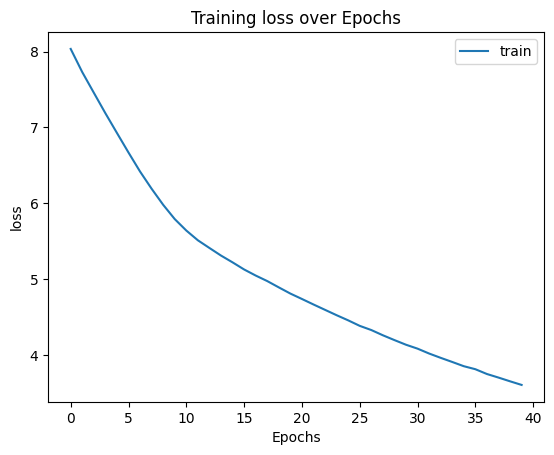

In [ ]:
plt.plot(train_losses, label='train')
plt.title('Training loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

# <b>8 <span style='color:#9146ff'>|</span> Evaluate</b>

In [ ]:
def evaluate(sent):
    sentence = src_tokenizer.texts_to_sequences([sent])
    sentence = pad_sequences(sentence, maxlen=SRC_MAXLEN, padding='post')
    src_input = torch.tensor(np.array(sentence), dtype=torch.int64)
    decoder_input = trg_tokenizer.texts_to_sequences(['<sos>'])
    decoder_input = torch.tensor(np.array(decoder_input), dtype=torch.int64)
    src_input, decoder_input = src_input.to(DEVICE), decoder_input.to(DEVICE)

    for i in range(TRG_MAXLEN):
        preds = model(src_input, decoder_input)
        preds = preds[:, -1:, :]
        predicted_id = torch.argmax(preds, dim=-1)
        if predicted_id.item() == trg_tokenizer.word_index['<eos>']:
            return decoder_input.squeeze(0)
        decoder_input = torch.cat([decoder_input, predicted_id], dim=1)

    return decoder_input.squeeze(0)

In [ ]:
test_sample = df.sample(100)
x_test = test_sample['src'].tolist()
y_test = test_sample['trg'].tolist()

In [ ]:
for idx, (src_sent, trg_sent) in enumerate(zip(x_test[-10:], y_test[-10:])):
    result = evaluate(src_sent)
    pred_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in result.cpu().numpy() if idx != 0 and idx != 2])
    print(f"Input sentence {idx+1} : {src_sent}")
    print(f"Actual summary {idx+1} : {trg_sent}")
    print(f"Predicted summary {idx+1} : {pred_sent}\n")

Input sentence 1 : dima hello nada hey girl whats up dima im in a huge trouble my laptop is broken and i have to deliver a translation tomorrow nada fuck what happened dima the stupid cat spilled coffee on it im freaking out dima you still have your old laptop is it possible to lend it to me please nada no sorry ive given it to my brother but youre lucky ive taken these two days off so you can take mine dima ooh man thank you sooo much if it werent for trados i wouldnt be panicking nada no worries it happened but i always think about this like man we need some back up laptops dima i know but i always change my mind and spend the money elsewhere lol nada yeah but its like our only tool so we need to invest in it dima yup true dima can i come in an hour to pick it up nada yes ttyl
Actual summary 1 : <sos> dima's laptop is broken as her cat spilled coffee on the laptop dima is worried because she has to deliver a translation for trados tomorrow dima will come to nada in an hour to borrow 